In [1]:
include("jl/omega.jl")
include("jl/HSBM.jl")
include("jl/objectives.jl")

using PyPlot

In [2]:
function read_hypergraph_data(dataname::String)
    labels = Int64[]
    open("data/$dataname/node-labels-$dataname.txt") do f
        for line in eachline(f)
            push!(labels, parse(Int64, line))
        end
    end
    n = length(labels)

    E = Dict{Integer, Dict}()
    open("data/$dataname/hyperedges-$dataname.txt") do f
        for line in eachline(f)
            edge = [parse(Int64, v) for v in split(line, ',')]
            sort!(edge)
            sz = length(edge)
            if !haskey(E, sz)
                E[sz] = Dict{}()
            end
            E[sz][edge] = 1
        end
    end
    
    D = zeros(Int64, n)
    for (sz, edges) in E
        for (e, _) in edges
            D[e] .+= 1
        end
    end
    
    return hypergraph(E, D), labels
end

read_hypergraph_data (generic function with 1 method)

In [3]:
# size 2/3 hyperedges in walmart-trips data
H, labels = read_hypergraph_data("walmart-trips-restricted")

(hypergraph
  E: Dict{Integer,Dict}
  D: Array{Integer}((5669,)) Integer[9, 1, 1, 12, 1, 4, 1, 11, 5, 10  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
, [11, 7, 7, 11, 7, 11, 11, 7, 7, 11  …  1, 3, 6, 10, 7, 8, 5, 7, 7, 2])

In [4]:
# Example with fixed omega
Ω_dict = Dict{Array{Int64,1}, Float64}()
for k = 1:3, p in partitions(k)
    Ω_dict[p] = 1e-5
    if p == [1, 1];    Ω_dict[p] = 1e-4; end
    if p == [2, 1];    Ω_dict[p] = 1e-4; end
    if p == [1, 1, 1]; Ω_dict[p] = 1e-4; end
end
Ω = ΩFromDict(Ω_dict)
L(H, labels, Ω)

(-4.23927742249333257929719553889165765091229243211046195938251912593841552734375e+08, 33168.20391985842, 6842.742789399427)

In [5]:
function construct_Ω(a, b, c)
    Ω_dict = Dict{Array{Int64,1}, Float64}()
    for k = 1:3, p in partitions(k)
        Ω_dict[p] = 1e-5
        if p == [1, 1];    Ω_dict[p] = a; end
        if p == [2, 1];    Ω_dict[p] = b; end
        if p == [1, 1, 1]; Ω_dict[p] = c; end
    end
    return ΩFromDict(Ω_dict)
end

construct_Ω (generic function with 1 method)

In [6]:
a = 1e-4
b = 1e-4
cs = 1e-4:1e-4:1e-2
lls = [L(H, labels, construct_Ω(a, b, c))[1] for c in cs]

100-element Array{BigFloat,1}:
 -4.23927742249333257929719553889165765091229243211046195938251912593841552734375e+08
 -5.74219068585687584474889615296960463340647518037940244539640843868255615234375e+08
 -7.24510405566278530515673728234428050375137697614036369486711919307708740234375e+08
 -8.74801746904841917683861309643845636206671567691728341742418706417083740234375e+08
 -1.025093090631330506067173073070784481385098185768356415792368352413177490234375e+09
 -1.175384435868232810360459910343781573215105051843920591636560857295989990234375e+09
 -1.325675782147457724643218563914396821400154546921612563892267644405364990234375e+09
 -1.475967129189596265835698860217632308843016541999304536147974431514739990234375e+09
 -1.626258476814423852278794178826269354286304658074868711992166936397552490234375e+09
 -1.776549824898884841052956829341312092705729153152560684247873723506927490234375e+09
 -1.926841173355208256474686670086247561838044273230252656503580510616302490234375e+09
 -2.077132522118

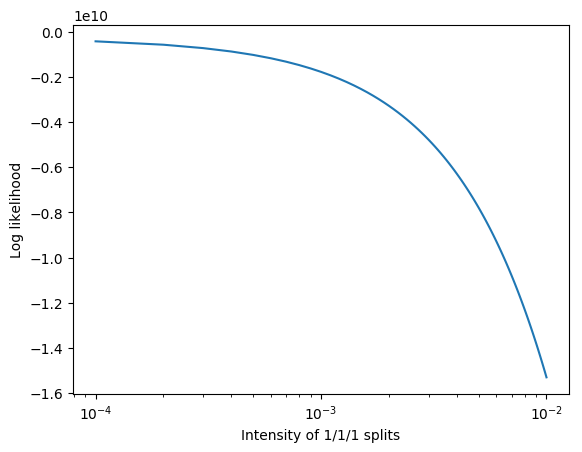

In [10]:
semilogx(cs, lls)
xlabel("Intensity of 1/1/1 splits")
ylabel("Log likelihood")
;